In [1]:
from dotenv import load_dotenv
load_dotenv()

False

In [2]:
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate

model = ChatOpenAI(
    model="gpt-4o-mini",   # usa un modelo que tengas habilitado
    temperature=0
)
print("🤖 Modelo listo")

🤖 Modelo listo


In [3]:
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
import os

In [4]:
import os, json
from datetime import datetime

# === Función para auditar código ===
def audit_code(file_path: str):
    """
    Realiza una auditoría de seguridad del archivo indicado
    usando el modelo inicializado en LangChain.
    """
    with open(file_path, "r", encoding="utf-8", errors="ignore") as f:
        code = f.read()

    prompt_template = """Eres un experto en seguridad OWASP.
    Analiza el siguiente código en busca de vulnerabilidades y responde en JSON válido.
    El formato debe ser:
    {{
      "file": "{file_name}",
      "vulnerabilities": [
        {{
          "title": "...",
          "severity": "CRITICAL|HIGH|MEDIUM|LOW",
          "cwe_id": "CWE-###",
          "description": "...",
          "line_numbers": [<int>],
          "recommendation": "..."
        }}
      ]
    }}

    Código:
    ```{code_lang}
    {code}
    ```"""

    # Crea el prompt
    prompt = prompt_template.format(
        file_name=os.path.basename(file_path),
        code_lang="C# (ASP.NET WebForms)",
        code=code[:4000]  # truncar si el archivo es muy largo
    )

    response = model.invoke(prompt)

    # Guarda el resultado en carpeta results
    os.makedirs("results", exist_ok=True)
    ts = datetime.now().strftime("%Y%m%d_%H%M%S")
    out_file = f"results/{os.path.basename(file_path)}_audit_{ts}.json"

    try:
        data = json.loads(response.content)
    except Exception:
        data = {"error": "Respuesta no es JSON válido", "raw": response.content}

    with open(out_file, "w", encoding="utf-8") as f:
        json.dump(data, f, ensure_ascii=False, indent=2)

    print(f"✅ Auditoría guardada en {out_file}")
    return data


In [5]:
import glob

# Buscar archivos .cs, .aspx, .asax dentro de /codigos
files = []
for ext in ("*.cs", "*.aspx", "*.asax", "*.config"):
    files.extend(glob.glob(os.path.join("codigos", "**", ext), recursive=True))

print(f"Encontrados {len(files)} archivos para auditar")

# Auditar todos
for f in files:
    print(f"🔍 Auditando: {f}")
    audit_code(f)


Encontrados 13 archivos para auditar
🔍 Auditando: codigos/Default.aspx.designer.cs


✅ Auditoría guardada en results/Default.aspx.designer.cs_audit_20251016_000545.json
🔍 Auditando: codigos/User.cs


✅ Auditoría guardada en results/User.cs_audit_20251016_000549.json
🔍 Auditando: codigos/JwtHelpers.cs


✅ Auditoría guardada en results/JwtHelpers.cs_audit_20251016_000556.json
🔍 Auditando: codigos/Default.aspx.cs


✅ Auditoría guardada en results/Default.aspx.cs_audit_20251016_000601.json
🔍 Auditando: codigos/Global.asax.cs


✅ Auditoría guardada en results/Global.asax.cs_audit_20251016_000606.json
🔍 Auditando: codigos/Login.aspx.designer.cs


✅ Auditoría guardada en results/Login.aspx.designer.cs_audit_20251016_000611.json
🔍 Auditando: codigos/Login.aspx.cs


✅ Auditoría guardada en results/Login.aspx.cs_audit_20251016_000618.json
🔍 Auditando: codigos/UserData.cs


✅ Auditoría guardada en results/UserData.cs_audit_20251016_000624.json
🔍 Auditando: codigos/AuthServices.cs


✅ Auditoría guardada en results/AuthServices.cs_audit_20251016_000632.json
🔍 Auditando: codigos/Default.aspx


✅ Auditoría guardada en results/Default.aspx_audit_20251016_000635.json
🔍 Auditando: codigos/Login.aspx


✅ Auditoría guardada en results/Login.aspx_audit_20251016_000644.json
🔍 Auditando: codigos/Global.asax


✅ Auditoría guardada en results/Global.asax_audit_20251016_000646.json
🔍 Auditando: codigos/Web.config


✅ Auditoría guardada en results/Web.config_audit_20251016_000654.json


In [6]:
import json, glob

summary = {"CRITICAL":0, "HIGH":0, "MEDIUM":0, "LOW":0, "UNKNOWN":0}

for file in glob.glob("results/*_audit_*.json"):
    with open(file, "r", encoding="utf-8") as f:
        data = json.load(f)
        for v in data.get("vulnerabilities", []):
            sev = v.get("severity", "UNKNOWN").upper()
            if sev in summary: summary[sev]+=1
            else: summary["UNKNOWN"]+=1

print("📊 Resumen general:")
for s, n in summary.items():
    print(f"{s:9}: {n}")


📊 Resumen general:
CRITICAL : 0
HIGH     : 0
MEDIUM   : 0
LOW      : 0
UNKNOWN  : 0


In [7]:
# === Auditoría de carpeta de código y guardado de resultados ===
import os, json
from pathlib import Path
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt

# Rutas del repo
REPO_DIR     = Path(".").resolve()
CODE_DIR     = REPO_DIR / "codigos"              # Carpeta principal de código
CODE_INSEG   = REPO_DIR / "codigos_inseguro"     # (Opcional) versión insegura
CODE_SEG     = REPO_DIR / "codigos_seguro"       # (Opcional) versión segura
RESULTS_DIR  = REPO_DIR / "results"              # Carpeta donde se guardan los JSON
RESULTS_DIR.mkdir(exist_ok=True)

# Extensiones a auditar
EXTS = {".cs", ".aspx", ".config", ".cshtml", ".vb", ".xml"}

def archivos_en(carpeta: Path):
    if not carpeta.exists():
        return []
    return [p for p in carpeta.rglob("*") if p.suffix.lower() in EXTS and p.is_file()]

def auditar_carpeta(carpeta_codigo: Path, carpeta_resultados: Path, etiqueta: str):
    """
    Recorre la carpeta de código, llama a tu función de auditoría por archivo y
    guarda un JSON por cada archivo analizado en 'carpeta_resultados'.
    El nombre del archivo resultante incluye la etiqueta y un timestamp.
    """
    print(f"▶ Auditando: {carpeta_codigo} -> {carpeta_resultados} ({etiqueta})")
    carpeta_resultados.mkdir(exist_ok=True, parents=True)
    ts = datetime.now().strftime("%Y%m%d_%H%M%S")

    total = 0
    for file_path in archivos_en(carpeta_codigo):
        total += 1
        # === LLAMADA A TU FUNCIÓN YA DEFINIDA ARRIBA ===
        # Debe retornar un dict con el análisis o bien guardar internamente el JSON.
        # Si tu función ya guarda el JSON, puedes omitir el bloque "with open(...)"
        # y sólo usar la llamada. Aquí asumimos que retorna un dict 'resultado'.
        try:
            resultado = audit_file_with_ai(str(file_path))  # <-- usa tu función anterior
        except NameError:
            raise RuntimeError(
                "No se encontró la función 'audit_file_with_ai'. "
                "Define arriba tu función que audite un archivo y devuelva un dict."
            )

        # Guardar cada resultado como JSON individual
        out_name = f"{etiqueta}_{file_path.stem}_audit_{ts}.json"
        out_path = carpeta_resultados / out_name
        with open(out_path, "w", encoding="utf-8") as f:
            json.dump(resultado, f, ensure_ascii=False, indent=2)
    print(f"✔ Archivos auditados: {total}")

def normaliza_severidad(s: str) -> str:
    if not s: return "low"
    s = s.strip().lower()
    if s.startswith("crit"): return "critical"
    if s.startswith("alt"):  return "high"
    if s.startswith("med"):  return "medium"
    if s.startswith("baj"):  return "low"
    return s if s in {"critical","high","medium","low"} else "low"

def resume_resultados(carpeta_resultados: Path, filtro_etiqueta: str = None) -> dict:
    """
    Lee todos los JSON en 'carpeta_resultados' (opcionalmente filtrando por etiqueta en el nombre)
    y cuenta vulnerabilidades por severidad. Se espera que cada JSON tenga una lista de
    vulnerabilidades con campo 'severity' o similar.
    """
    counts = {"critical": 0, "high": 0, "medium": 0, "low": 0}
    total_json = 0

    for p in carpeta_resultados.glob("*.json"):
        if filtro_etiqueta and not p.name.startswith(filtro_etiqueta + "_"):
            continue
        total_json += 1
        try:
            data = json.loads(p.read_text(encoding="utf-8"))
        except Exception:
            continue

        # Adapta a tu estructura: intentamos varias claves comunes
        vulns = []
        if isinstance(data, dict):
            if "vulnerabilities" in data and isinstance(data["vulnerabilities"], list):
                vulns = data["vulnerabilities"]
            elif "issues" in data and isinstance(data["issues"], list):
                vulns = data["issues"]

        for v in vulns:
            sev = None
            if isinstance(v, dict):
                sev = v.get("severity") or v.get("level") or v.get("severity_level")
            counts[normaliza_severidad(str(sev))] += 1

    total_vulns = sum(counts.values())
    # Estructura resumen (compat con tu snippet original)
    resumen = {
        "critical": counts["critical"],
        "high": counts["high"],
        "medium": counts["medium"],
        "low": counts["low"],
        "vulnerabilities": total_vulns,
        "archivos_analizados": total_json,
    }
    return resumen

# === 1) Auditar carpeta principal 'codigos/' ===
if CODE_DIR.exists():
    auditar_carpeta(CODE_DIR, RESULTS_DIR, etiqueta="codigos")

# === 2) (Opcional) Auditar dos versiones para comparación ===
security_results = None
secure_results   = None

if CODE_INSEG.exists():
    auditar_carpeta(CODE_INSEG, RESULTS_DIR, etiqueta="inseguro")
    security_results = resume_resultados(RESULTS_DIR, filtro_etiqueta="inseguro")

if CODE_SEG.exists():
    auditar_carpeta(CODE_SEG, RESULTS_DIR, etiqueta="seguro")
    secure_results = resume_resultados(RESULTS_DIR, filtro_etiqueta="seguro")

# Si no hay versiones separadas, hacemos un resumen único de 'codigos/'
if security_results is None and secure_results is None:
    unico = resume_resultados(RESULTS_DIR, filtro_etiqueta="codigos")
    print("Resumen (carpeta 'codigos/'):")
    print(unico)

# === 3) Construir la comparación (si hay dos versiones) y graficar ===
if security_results and secure_results:
    comparison_data = pd.DataFrame([
        {
            'Version': 'Código Inseguro',
            'High':   security_results.get('high', 0),
            'Medium': security_results.get('medium', 0),
            'Low':    security_results.get('low', 0)
        },
        {
            'Version': 'Código Seguro',
            'High':   secure_results.get('high', 0),
            'Medium': secure_results.get('medium', 0),
            'Low':    secure_results.get('low', 0)
        }
    ])

    fig, ax = plt.subplots(figsize=(10, 6))
    # Nota: no fijamos colores para mantenerlo genérico
    comparison_data.set_index('Version')[['High', 'Medium', 'Low']].plot(kind='bar', ax=ax)
    plt.title('Comparación de Vulnerabilidades: Código Inseguro vs Seguro', fontsize=14, fontweight='bold')
    plt.xlabel('Versión del Código', fontsize=12)
    plt.ylabel('Número de Vulnerabilidades', fontsize=12)
    plt.legend(title='Severidad', loc='upper right')
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()

    reduccion = security_results.get('vulnerabilities', 0) - secure_results.get('vulnerabilities', 0)
    print("\n📊 Conclusión:")
    print(f"Reducción de vulnerabilidades: {reduccion}")

else:
    print("\nℹ No se detectaron ambas versiones ('codigos_inseguro/' y 'codigos_seguro/').")
    print("   Se generó/actualizó el resumen único de la carpeta 'codigos/' y los JSON en 'results/'.")


▶ Auditando: /home/runner/work/AutenticacionSegura/AutenticacionSegura/codigos -> /home/runner/work/AutenticacionSegura/AutenticacionSegura/results (codigos)


RuntimeError: No se encontró la función 'audit_file_with_ai'. Define arriba tu función que audite un archivo y devuelva un dict.

In [8]:
# === Comparar resultados de auditoría ===
from pathlib import Path
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import json
import os

# --- Rutas del repositorio ---
codigos_path = Path("codigos")
results_path = Path("results")
results_path.mkdir(exist_ok=True)

# --- Cargar resultados JSON de auditorías previas ---
# Asegúrate de que existan archivos results del código inseguro y seguro
insecure_file = next(results_path.glob("*inseguro*.json"), None)
secure_file = next(results_path.glob("*seguro*.json"), None)

if not insecure_file or not secure_file:
    print("⚠️ No se encontraron archivos de resultados (inseguro y seguro).")
else:
    with open(insecure_file, "r", encoding="utf-8") as f:
        insecure_data = json.load(f)
    with open(secure_file, "r", encoding="utf-8") as f:
        secure_data = json.load(f)

    # --- Contar vulnerabilidades por nivel ---
    def contar_vulnerabilidades(data):
        conteo = {"high": 0, "medium": 0, "low": 0, "total": 0}
        if isinstance(data, dict) and "vulnerabilities" in data:
            for v in data["vulnerabilities"]:
                sev = v.get("severity", "").lower()
                if sev in conteo:
                    conteo[sev] += 1
                    conteo["total"] += 1
        return conteo

    security_results = contar_vulnerabilidades(insecure_data)
    secure_results = contar_vulnerabilidades(secure_data)

    # --- Preparar datos para comparar ---
    comparison_data = pd.DataFrame([
        {
            'Versión': 'Código Inseguro',
            'Críticas': security_results['high'],
            'Medias': security_results['medium'],
            'Bajas': security_results['low']
        },
        {
            'Versión': 'Código Seguro',
            'Críticas': secure_results['high'],
            'Medias': secure_results['medium'],
            'Bajas': secure_results['low']
        }
    ])

    # --- Crear gráfica ---
    fig, ax = plt.subplots(figsize=(10, 6))
    comparison_data.set_index('Versión')[['Críticas', 'Medias', 'Bajas']].plot(
        kind='bar',
        ax=ax,
        color=['#e74c3c', '#f39c12', '#f1c40f']
    )
    plt.title('Comparación de Vulnerabilidades: Código Inseguro vs Seguro', fontsize=14, fontweight='bold')
    plt.xlabel('Versión del Código', fontsize=12)
    plt.ylabel('Número de Vulnerabilidades', fontsize=12)
    plt.legend(title='Severidad', loc='upper right')
    plt.xticks(rotation=0)
    plt.tight_layout()

    # --- Guardar la imagen en /results ---
    img_path = results_path / "comparacion_vulnerabilidades.png"
    plt.savefig(img_path, bbox_inches="tight")
    plt.show()

    # --- Mostrar conclusión ---
    reduccion = security_results["total"] - secure_results["total"]
    print("\n📊 Conclusión:")
    if reduccion > 0:
        print(f"Se redujeron {reduccion} vulnerabilidades en el código seguro respecto al inseguro.")
    elif reduccion == 0:
        print("No hubo diferencia en el número de vulnerabilidades detectadas.")
    else:
        print(f"⚠️ Se detectaron {abs(reduccion)} vulnerabilidades más en el código seguro (revisar configuración).")

    print(f"📁 Gráfica guardada en: {img_path}")


⚠️ No se encontraron archivos de resultados (inseguro y seguro).


🧩 Comparando:
 - Web.config_audit_20251016_000654.json
 - Global.asax_audit_20251016_000646.json


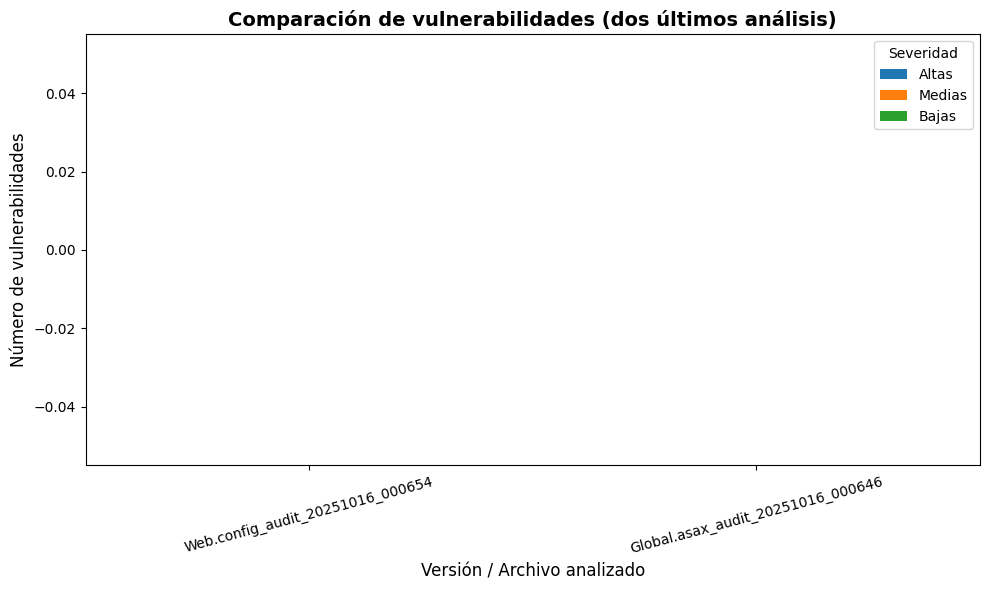


📊 Conclusión:
No hubo diferencia en el número de vulnerabilidades.
📁 Gráfica guardada en: results/comparacion_vulnerabilidades.png


In [9]:
from pathlib import Path
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import json, os

results_path = Path("results")
results_path.mkdir(exist_ok=True)

# Buscar los dos archivos JSON más recientes
json_files = sorted(results_path.glob("*.json"), key=os.path.getmtime, reverse=True)

if len(json_files) < 2:
    print("⚠️ No hay suficientes archivos de resultados (.json) en 'results'. Ejecuta primero la auditoría.")
else:
    a_file, b_file = json_files[:2]
    print(f"🧩 Comparando:\n - {a_file.name}\n - {b_file.name}")

    with open(a_file, "r", encoding="utf-8") as f:
        a_data = json.load(f)
    with open(b_file, "r", encoding="utf-8") as f:
        b_data = json.load(f)

    def contar_vulnerabilidades(data):
        counts = {"high":0, "medium":0, "low":0, "total":0}
        for v in data.get("vulnerabilities", []):
            sev = (v.get("severity") or "").lower()
            if sev in counts:
                counts[sev] += 1
                counts["total"] += 1
        return counts

    a_counts = contar_vulnerabilidades(a_data)
    b_counts = contar_vulnerabilidades(b_data)

    df = pd.DataFrame([
        {"Versión": a_file.stem, "Altas": a_counts["high"], "Medias": a_counts["medium"], "Bajas": a_counts["low"]},
        {"Versión": b_file.stem, "Altas": b_counts["high"], "Medias": b_counts["medium"], "Bajas": b_counts["low"]},
    ])

    # Graficar
    fig, ax = plt.subplots(figsize=(10, 6))
    df.set_index("Versión")[["Altas","Medias","Bajas"]].plot(kind="bar", ax=ax)
    plt.title("Comparación de vulnerabilidades (dos últimos análisis)", fontsize=14, fontweight="bold")
    plt.xlabel("Versión / Archivo analizado", fontsize=12)
    plt.ylabel("Número de vulnerabilidades", fontsize=12)
    plt.legend(title="Severidad", loc="upper right")
    plt.xticks(rotation=15)
    plt.tight_layout()

    # Guardar PNG en /results
    img_path = results_path / "comparacion_vulnerabilidades.png"
    plt.savefig(img_path, bbox_inches="tight")
    plt.show()

    reduccion = a_counts["total"] - b_counts["total"]
    print("\n📊 Conclusión:")
    if reduccion > 0:
        print(f"Se redujeron {reduccion} vulnerabilidades en el análisis más reciente.")
    elif reduccion == 0:
        print("No hubo diferencia en el número de vulnerabilidades.")
    else:
        print(f"⚠️ Se detectaron {abs(reduccion)} vulnerabilidades más en el último análisis.")
    print(f"📁 Gráfica guardada en: {img_path}")


In [10]:
import json
from pathlib import Path

# --- Configuración del Quality Gate ---
results_path = Path("results")
high_limit = 0       # No se permiten vulnerabilidades críticas
medium_limit = 3     # Máximo 3 medias
low_limit = 10       # Máximo 10 bajas

print("🚧 Validando Quality Gate...\n")

# --- Buscar archivos JSON con resultados ---
json_files = sorted(results_path.glob("*.json"))

if not json_files:
    print("⚠️ No se encontraron archivos de resultados en la carpeta 'results/'. Ejecuta primero la auditoría.")
else:
    summary = []
    for file in json_files:
        with open(file, "r", encoding="utf-8") as f:
            data = json.load(f)

        counts = {"high": 0, "medium": 0, "low": 0}
        for v in data.get("vulnerabilities", []):
            sev = (v.get("severity") or "").lower()
            if sev in counts:
                counts[sev] += 1

        summary.append({
            "archivo": file.name,
            "altas": counts["high"],
            "medias": counts["medium"],
            "bajas": counts["low"]
        })

    # --- Evaluar Quality Gate ---
    passed = True
    for item in summary:
        if (item["altas"] > high_limit) or (item["medias"] > medium_limit) or (item["bajas"] > low_limit):
            passed = False

    # --- Guardar reporte ---
    qg_report = {
        "fecha": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
        "criterios": {
            "High": high_limit,
            "Medium": medium_limit,
            "Low": low_limit
        },
        "resultados": summary,
        "estado": "APROBADO" if passed else "FALLÓ"
    }

    out_path = results_path / f"quality_gate_{datetime.now().strftime('%Y%m%d_%H%M%S')}.json"
    with open(out_path, "w", encoding="utf-8") as f:
        json.dump(qg_report, f, indent=4, ensure_ascii=False)

    # --- Mostrar resultado ---
    print("✅ QUALITY GATE APROBADO" if passed else "❌ QUALITY GATE FALLÓ")
    print(f"📁 Reporte guardado en: {out_path}")


🚧 Validando Quality Gate...

✅ QUALITY GATE APROBADO
📁 Reporte guardado en: results/quality_gate_20251016_000659.json
